In [ ]:
import scipy
from scipy.stats import median_abs_deviation as mad
import numpy as np
from matplotlib import pyplot as plt
import time
from  scipy.io import loadmat as loadmat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Image Processing/lez25_Multi_Model_Fitting')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Image Processing/lez25_Multi_Model_Fitting'

Useful function for the plot

In [ ]:
def display_band( X, par,epsi=0.001,col='k'):
    x1 = np.min(X[0, :])
    x2 = np.max(X[0, :])
    y1 = np.min(X[1, :])
    y2 = np.max(X[1, :])

    # extend the line for the k# of its lenght
    k = 0.01
    dx = x2-x1
    dy = y2-y1
    l = np.sqrt(dx**2+dy**2)
    x1 = x1 - k*l
    x2 = x2 + k*l
    y1 = y1 - k*l
    y2 = y2 + k*l
    ##
    if np.abs(par[1])<2e-2 :
        #disp('vertical line')
        a = np.vstack([-(par[1]*y1 + par[2])/par[0], y1])
        b = np.vstack([-(par[1]*y2 + par[2])/par[0], y2])
    else:
        a = np.vstack([x1, -(par[0]*x1 + par[2])/par[1]])
        b = np.vstack([x2, -(par[0]*x2 + par[2])/par[1]])

    if np.abs(par[0])<1e-5:
        v = np.array([0,1])
    else:
        v = np.array([1, par[1]/par[0]])# direction perpendicular to the line;

    v = v / np.sqrt(np.sum(v**2))
    # corners of the bands
    v = v[:, np.newaxis]
    a1 = a - epsi * v
    a2 = a + epsi * v
    b1 = b - epsi * v
    b2 = b + epsi * v

    px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
    py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
    plt.tricontourf(px,py,np.ones_like(px), colors=col,alpha=0.5)
    plt.gca().set_aspect('equal')

def display_clust(X, G, cmap):
    G = np.asarray(G, dtype=int)
    switch_out = 1
    smb = 'o'
    col = []
    num_clust = int(np.max(G))

    for i in range(1, num_clust+1):
        id = G == i
        id = id.squeeze()
        x = X[0, id]
        y = X[1, id]
        if len(col) == 0:
            plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
        else:
            plt.scatter(x,y,50,col,marker=smb,edgecolors=col, alpha=0.1)
        if switch_out == 1:
            id = G == 0
            id = id.squeeze()
            plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)

Function that computes the residual between points and a line

In [ ]:
def res_line(X, M):
  if len(M.shape) > 1:
    num_lines = M.shape[1]
  else:
    num_lines = 1

  if num_lines == 1:
    d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2])
  else:
    n = X.shape[1]
    d = np.zeros((n, num_lines))
    for i in range(num_lines):
      d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i])

Functions to add outlier to the dataset

In [ ]:
def addOutliersInBB(X, nOutliers, k=0.1):
    xmin = np.min(X[0, :])
    xmax = np.max(X[0, :])
    ymin = np.min(X[1, :])
    ymax = np.max(X[1, :])
    wx = xmax-xmin
    wy = ymax -ymin
    dx = k*wx
    dy = k*wy

    Y = np.hstack((X,np.vstack((xmax-xmin+2*dx * np.random.uniform(size=(1, nOutliers)) + xmin-dx,
                             ymax-ymin+2*dy * np.random.uniform(size=(1, nOutliers)) + ymin-dy))
                ))
    return Y

Ransac for lines
------
Use the implementation from the last lecture

In [158]:
def fit_line_dlt(P):
  # design matrix
  A = np.hstack((P.T,np.ones((P.shape[1],1))))
  # vector of responses
  y = P.T[:, 1]

  # SVD
  U, s, Vh = np.linalg.svd(A)
  theta = Vh.T[:,2]

  residuals = A @ theta
  residual_error = np.sum(residuals ** 2)

  return theta, residuals, residual_error

In [159]:
def simpleRANSAC(X, eps, cardmss = 2):
  """
  SIMPLERANSAC
  X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
  """
  # number of samples in the dataset
  n = X.shape[1]
  # Desired probability of success
  alpha = 0.99

  # Pessimistic estimate of inliers fraction
  f = 0.5

  # I use this matrix to evaluate the residuals from any point to the fitted model
  A = np.hstack((X.T,np.ones((X.shape[1],1))))

  # set maximum number of iterations
  MaxIterations = min(int(np.log(1-alpha) / np.log(1-(1-f)**cardmss)),30)

  # set maximum consensus reached
  maxscore = - np.inf

  # this will change under some conditions, if we reach it, we stop
  max_iter = MaxIterations
  for i in range(MaxIterations):

    # Generate cardmss random indices in the range 0..n-1
    # this should contain the two observations ready for the fitting
    #idx = np.random.randint(0, n-1, size=cardmss)   # row index of the two points in X.T
    idx = np.random.choice(np.arange(0, n), size=cardmss, replace=False)

    mss = X.T[idx]

    # Fit model to this minimal sample set.
    theta, _, _ = fit_line_dlt(mss.T)

    # Evaluate distances between points and model
    sqres = np.abs(A@theta)

    # identify inliers: consensus set
    inliers = np.where(sqres <= eps)[0]

    # assess consensus (the number of inliers)
    score = len(inliers)

    # replace maxscore, bestinliers and bestmodel if needed
    if score > maxscore:
      maxscore = score
      bestinliers = inliers
      bestmodel = theta

      f = (n - maxscore)/n  # proportion of outliers
      max_iter = int(np.log(1-alpha)/(np.log(1-(1-f)**cardmss)))

    if i == max_iter:
      break

  return bestmodel, bestinliers

Sequential Ransac
-----------------
Prepare the dataset and set the parameters


In [160]:
epsi = 0.02 # inlier threshold for ransac

#temp = loadmat(f'{rootfolder}/data/star5.mat')
temp = loadmat(f'./data/star5.mat')

X = temp['X'] # data
G = temp['G'] # ground truth or label (>=1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 2          # minimum number of points required to fit a model
kappa = 5           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'./data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers
G = np.vstack((G, np.zeros((nOut,1))))

<ipython-input-4-afb5a87e94f6>:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
<ipython-input-4-afb5a87e94f6>:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)


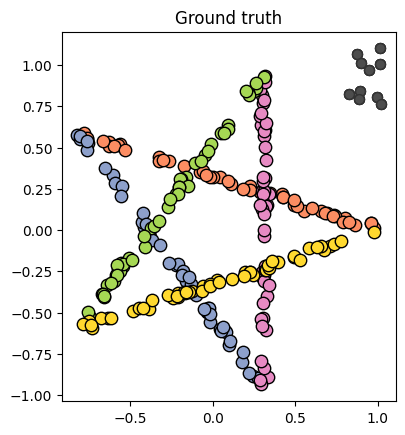

In [161]:
plt.figure(1)
display_clust(X,G, cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

Implement the sequential ransac algorithm

In [165]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac
    model, inliers = simpleRANSAC(Y, epsi, cardmss)

    # LS refinment over the inliers found with ransac
    theta, residuals, residual_error = fit_line_dlt(Y[:, inliers])

    # Evaluate distances between points and model
    A = np.hstack((Y.T,np.ones((Y.shape[1],1))))
    sqres = np.abs(A@theta)
    # identify inliers: consensus set
    inliers = np.where(sqres <= epsi)[0]

    # stop the loop if there is no more models to find
    if (len(inliers) < E_min):
        break

    # save currentModel and currentInliers for visualization
    currentInliers.append(inliers)
    currentModel.append(theta)

    # remove current inliers
    Y = np.delete(Y, inliers, axis=1)
    if (Y.shape[1] < cardmss):
      break

    # update iterations
    cnt = cnt + 1

Show the iteration of Sequential Ransac


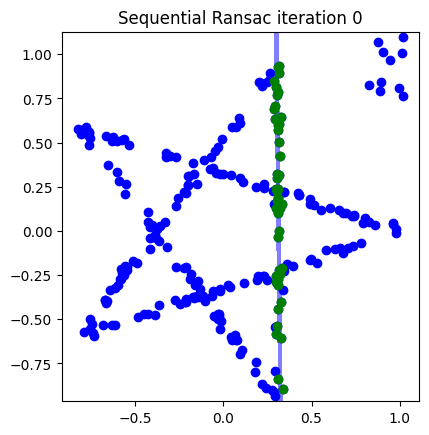

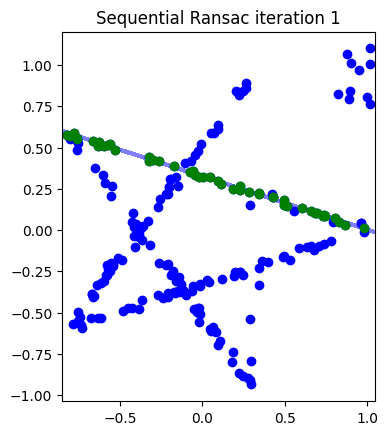

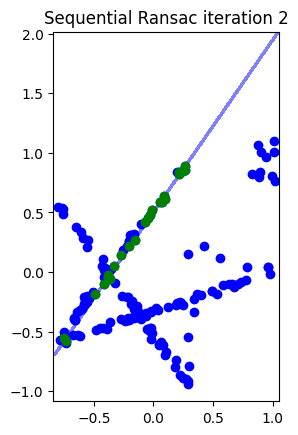

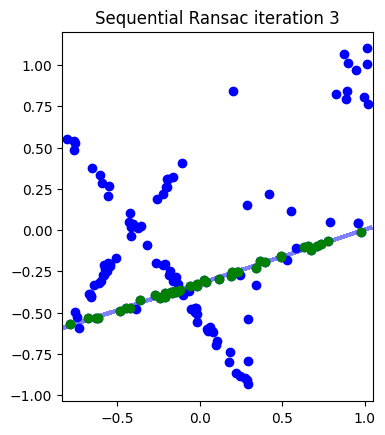

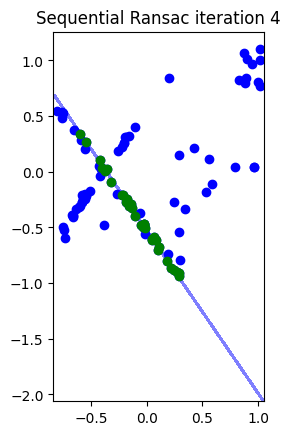

In [166]:
Y = X.copy()
plt.gca().set_aspect('equal')
for i in range(cnt):

    # display a band for each model estimated (see display_band function)
    display_band(Y, currentModel[i], bw, col)

    # plot inliers for this model
    plt.scatter(Y[0, :], Y[1, :], c='blue')
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]], c='green')

    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y,currentInliers[i], axis=1)

    plt.title(f'Sequential Ransac iteration {i:d}')

    plt.show()

# MultiModel fitting on circle

In [173]:
epsi = 0.02 # inlier threshold for ransac

#temp = loadmat(f'{rootfolder}/data/star5.mat')
temp = loadmat(f'./data/circle5.mat')

X = temp['X'] # data
G = temp['G'] # ground truth or label (>=1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 3          # minimum number of points required to fit a model
kappa = 5           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'./data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers
G = np.vstack((G, np.zeros((nOut,1))))

<ipython-input-4-afb5a87e94f6>:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
<ipython-input-4-afb5a87e94f6>:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)


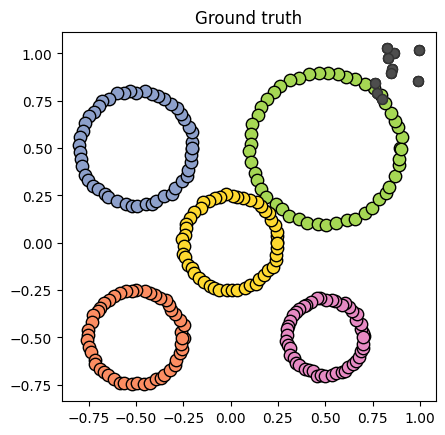

In [174]:
plt.figure(1)
display_clust(X,G,cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

Ransac for lines

In [175]:
def fit_circle_dlt(P):

  # design matrix
  n = P.shape[0]
  A = np.zeros((n-1,2))
  A[:,0] = (P[1:,0] - P[0,0]) * 2
  A[:,1] = (P[1:,1] - P[0,1]) * 2
  b = np.zeros(n-1)
  b += P[1:,0]**2
  b += P[1:,1]**2
  b -= P[0,0]**2
  b -= P[0,1]**2

  # Compute the parameters
  c_x, c_y = np.linalg.inv(A.T @ A) @ A.T @ b
  r = np.sqrt(P[0,0]**2 - 2*P[0,0]*c_x + c_x**2 + P[0,1]**2 -2*P[0,1]*c_y + c_y**2)
  theta = np.array([c_x, c_y, r])

  residuals = (P[:,0] - c_x)**2 + (P[:,1] - c_y)**2 - r**2
  residual_error = np.sum(residuals ** 2)

  return theta, residuals, residual_error

In [176]:
def simpleRANSAC(X, eps, cardmss = 3):
  """
  SIMPLERANSAC - Robust fit with the LMEDS algorithm
  X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
  """
  # number of samples in the dataset
  n = X.shape[1]

  # Desired probability of success
  alpha = 0.99

  # Pessimistic estimate of inliers fraction
  f = 0.5

  # I use this matrix to evaluate the residuals from any point to the fitted model
  A = X.T

  # set maximum number of iterations
  MaxIterations = min(int(np.log(1-alpha) / np.log(1-(1-f)**cardmss)),30)

  # set maximum consensus reached
  maxscore = - np.inf

  # this will change under some conditions, if we reach it, we stop
  max_iter = MaxIterations
  for i in range(MaxIterations):

    # Generate cardmss random indices in the range 0..n-1
    # this should contain the three observations ready for the fitting
    #idx = np.random.randint(0, n-1, size=cardmss)   # row index of the three points in X.T
    idx = np.random.choice(np.arange(0, n), size=cardmss, replace=False)

    mss = X.T[idx]

    # Fit model to this minimal sample set.
    theta, _, _ = fit_circle_dlt(mss)

    # Evaluate distances between points and model
    sqres = np.abs((A[:,0] - theta[0])**2 + (A[:,1] - theta[1])**2 - theta[2]**2)

    # identify inliers: consensus set
    inliers = np.where(sqres <= eps)[0]

    # assess consensus (the number of inliers)
    score = len(inliers)

    # replace maxscore, bestinliers and bestmodel if needed
    if score > maxscore:
      maxscore = score
      bestinliers = inliers
      bestmodel = theta

      f = (n - maxscore)/n  # proportion of outliers
      max_iter = int(np.log(1-alpha)/(np.log(1-(1-f)**cardmss)))

    if i == max_iter:
      break

  return bestmodel, bestinliers

Implement the sequential ransac algorithm

In [177]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 30 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac
    model, inliers = simpleRANSAC(Y, epsi, cardmss)

    # LS refinment over the inliers found with ransac
    theta, residuals, residual_error = fit_circle_dlt(Y[:, inliers].T)

    # Evaluate distances between points and model
    A = Y.T
    sqres = np.abs((A[:,0] - theta[0])**2 + (A[:,1] - theta[1])**2 - theta[2]**2)
    # identify inliers: consensus set
    inliers = np.where(sqres <= epsi)[0]

    # stop the loop if there is no more models to find
    if (len(inliers) < E_min):
        break

    # save currentModel and currentInliers for visualization
    currentInliers.append(inliers)
    currentModel.append(theta)

    # remove current inliers
    Y = np.delete(Y, inliers, axis=1)
    if (Y.shape[1] < cardmss):
      break

    # update iterations
    cnt = cnt + 1

Show the iteration of Sequential Ransac

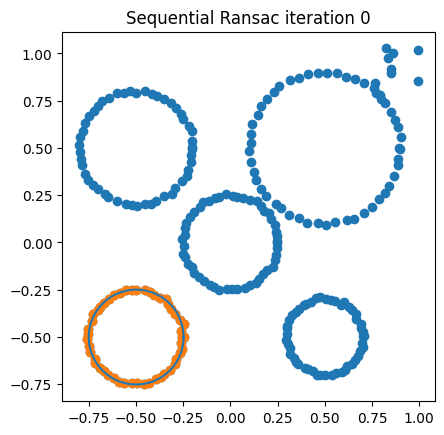

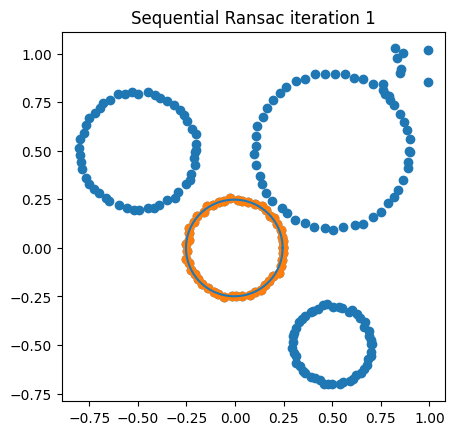

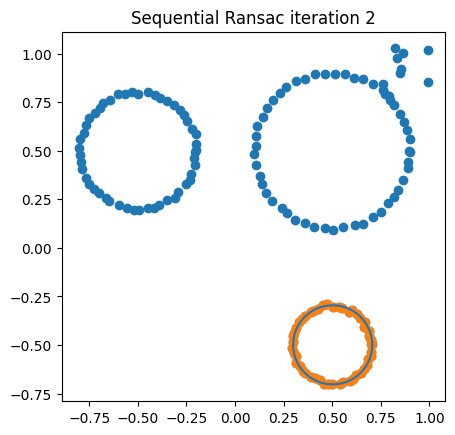

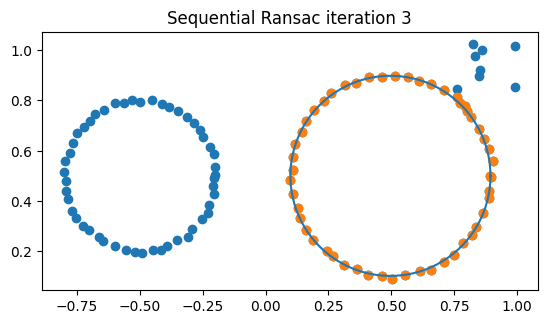

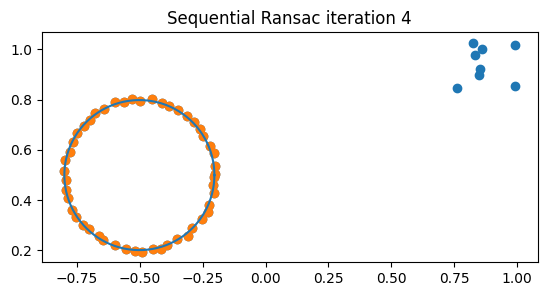

In [178]:
Y = X.copy()
plt.gca().set_aspect('equal')
for i in range(kappa):

    plt.gca().set_aspect('equal')
    th = np.linspace(0, 2*np.pi, 100)
    x = currentModel[i][0] + currentModel[i][2]*np.cos(th)
    y = currentModel[i][1] + currentModel[i][2]*np.sin(th)

    # plotting Y, so the points that are not considered are removed at each iteration
    plt.plot(x,y)
    plt.scatter(Y[0, :], Y[1, :])
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]])

    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y,currentInliers[i], axis=1)

    plt.title(f'Sequential Ransac iteration {i:d}')

    plt.show()